# 库导入

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import h5py
import xarray as xr
import rasterio as rio
from rasterio.crs import CRS
from rasterio.transform import from_bounds
from rasterio.warp import calculate_default_transform, reproject
from osgeo import gdal,gdalconst,ogr,osr,gdalnumeric
from osgeo.gdalconst import *


In [2]:
# 静态投影
raster = rio.open("./asi-AMSR2-s6250-20230701-v5.4.tif")
raster.crs # 坐标系
raster.transform # 仿射变换
raster.width  # 维度
raster.height # 维度
raster.count # 波段
raster.nodatavals # 缺失值
# raster.dirver # 数据格式
# 上面的所有信息，也可以通过raster.meta一次展示
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 1264,
 'height': 1328,
 'count': 1,
 'crs': CRS.from_epsg(3976),
 'transform': Affine(6250.0, 0.0, -3950000.0,
        0.0, -6250.0, 4350000.0)}

# 月平均

In [3]:
date_range = pd.date_range(start="20131201", end="20131231", freq="1M")
out_path = "./Data_Month"
for datearr in date_range:
    year,month = datearr.year,datearr.strftime("%m")
    outfile = os.path.join(out_path, datearr.strftime("%Y%m")) + ".nc"
    if not os.path.isdir(os.path.dirname(outfile)):
        os.makedirs(os.path.dirname(outfile))
    # if os.path.exists(outfile):
    #     continue
    filelist = glob.glob(f"./SIC/{year}/{month}/*-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc")
    sic = None
    for file in filelist:
        ds = xr.open_dataset(file)
        var = ds["sea_ice_fraction"]
        sic = var.copy() if sic is None else xr.concat([sic, var], dim="time")
    sic_mean = sic.mean(dim="time")
    lat = sic_mean.lat
    sic_s = sic_mean.sel(lat=lat[lat <= -40])
    sic_s.to_netcdf(f"{outfile}")
    print(outfile,np.nanmean(sic_s))

./Data_Month\201312.nc 0.17736264


# 投影转换

In [4]:
# 等经纬度转极地
def transform(src_img,dst_img):
    # src_img = 'tset.tif' # 输入图像
    # dst_img = 'output.tif' # 输出图像
    #dst_crs = crs.CRS.from_proj4('+proj=lcc +lat_1=15 +lat_2=65 +lat_0=30 +lon_0=95 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs') # 输出图像坐标系
    dst_crs = CRS.from_epsg(3976)
    
    src_ds = rio.open(src_img)
    # 更新数据集的元数据信息
    profile = src_ds.meta.copy()
    profile.update({
        'crs': raster.crs,
        'transform': raster.transform,
        'width': raster.width,
        'height': raster.height
        })
    
    # 重投影并写入数据
    with rio.open(dst_img, 'w', **profile) as dst_ds:
        for i in range(1, src_ds.count + 1): # 遍历每个图层，通常只需要第一层即可
            src_array = src_ds.read(i)
            dst_array = np.empty((raster.height, raster.width), dtype=profile['dtype']) # 初始化输出图像数据
            
            # 重投影
            reproject(
                # 源文件参数
                source=src_array,
                src_crs=src_ds.crs,
                src_transform=src_ds.transform,
                # 目标文件参数
                destination=dst_array,
                dst_transform=raster.transform,
                dst_crs=raster.crs,
                # 其它配置
                # resampling=Resampling.average,
                num_threads=2)
            # 写入图像
            dst_ds.write(dst_array, i)

def nc2tiff(inflie,outfile):
    # NC数据的坐标、空间参考、nodata信息
    # if os.path.exists(outfile):
    #     return
    ds = xr.open_dataset(inflie)
    lon,lat = ds.lon.values,ds.lat.values
    west, south, east, north = lon[0], lat[-1], lon[-1], lat[0]
    height,width = ds.sea_ice_fraction.shape
    meic_affine = from_bounds(west, south, east, north, width, height)
    crs = CRS.from_epsg(4326)
    nodata = np.nan
    array = ds.sea_ice_fraction
    out_path = outfile
    if not os.path.isdir(os.path.dirname(out_path)):
        os.makedirs(os.path.dirname(out_path))
    with rio.open(out_path, 'w', driver='GTiff', 
                height=height, width=width, 
                count=1, dtype=array.dtype, 
                crs=crs, transform=meic_affine, 
                nodata=nodata, compress='lzw') as dst:
        # 写入数据到输出文件
        dst.write(array, 1)

filelist = glob.glob("./Data_Month/*.nc")
filelist = [file for file in filelist if "_sst" not in file]
for file in filelist:
    tiffile = f"./Data_Month_TIFF/{os.path.basename(file)[0:-3]}.tif"
    nc2tiff(file,tiffile)
    polarfile = f"./Data_Month_TIFF/{os.path.basename(file)[0:-3]}-polar.tif"
    transform(tiffile,polarfile)
filelist

['./Data_Month\\201312.nc',
 './Data_Month\\201401.nc',
 './Data_Month\\201402.nc',
 './Data_Month\\201403.nc',
 './Data_Month\\201404.nc',
 './Data_Month\\201405.nc',
 './Data_Month\\201406.nc',
 './Data_Month\\201407.nc',
 './Data_Month\\201408.nc',
 './Data_Month\\201409.nc',
 './Data_Month\\201410.nc',
 './Data_Month\\201411.nc',
 './Data_Month\\201412.nc',
 './Data_Month\\201501.nc',
 './Data_Month\\201502.nc',
 './Data_Month\\201503.nc',
 './Data_Month\\201504.nc',
 './Data_Month\\201505.nc',
 './Data_Month\\201506.nc',
 './Data_Month\\201507.nc',
 './Data_Month\\201508.nc',
 './Data_Month\\201509.nc',
 './Data_Month\\201510.nc',
 './Data_Month\\201511.nc',
 './Data_Month\\201512.nc',
 './Data_Month\\201601.nc',
 './Data_Month\\201602.nc',
 './Data_Month\\201603.nc',
 './Data_Month\\201604.nc',
 './Data_Month\\201605.nc',
 './Data_Month\\201606.nc',
 './Data_Month\\201607.nc',
 './Data_Month\\201608.nc',
 './Data_Month\\201609.nc',
 './Data_Month\\201610.nc',
 './Data_Month\\2016

# 海域平均

In [5]:
# CCAMLR shp文件处理
def shp2raster(rasterFile,shpFile):
    rasterclip = shpFile.replace(".shp", ".tif")
    # 投影参数 维度参数 地理范围
    dataset = gdal.Open(rasterFile, gdalconst.GA_ReadOnly)
    geo_transform = dataset.GetGeoTransform()
    cols = dataset.RasterXSize  # 列数
    rows = dataset.RasterYSize  # 行数
    projection = dataset.GetProjection()
    del dataset
    
    # shp文件读取
    shp = ogr.Open(shpFile, 0)
    m_layer = shp.GetLayerByIndex(0)
    target_ds = gdal.GetDriverByName('GTiff').Create(rasterclip, xsize=cols, ysize=rows, bands=1,eType=gdal.GDT_Byte)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)

    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(0)
    band.FlushCache()
    gdal.RasterizeLayer(target_ds, [1], m_layer, options=["Datetime"]) # 跟shp字段给栅格像元赋值
    # gdal.RasterizeLayer(target_ds, [1], m_layer) # 多边形内像元值的全是255
    del target_ds
    shp.Release()
    return rasterclip

# 海域shp提取与存储
shpfile1 = "./data-main/geographical_data/ssru/ssru-shapefile-EPSG4326.shp"
shpfile2 = "./data-main/geographical_data/ssmu/ssmu-shapefile-EPSG4326.shp"
shp1 = gpd.read_file(shpfile1)
shp2 = gpd.read_file(shpfile2)
cosmonautsea = shp1[shp1.GAR_Short_.str.contains("5842")].reset_index(drop=True)
amundsenbs = shp1[(shp1.GAR_Short_.str.contains("883")) | (shp1.GAR_Short_.str.contains("882"))].reset_index(drop=True)
antarcticpeninsula = shp2[shp2.GAR_Name.str.contains("48.1")].reset_index(drop=True)

cosmonautseafile = "./Data_Month_TIFF/cosmonautsea.shp"
cosmonautsea.to_file(cosmonautseafile,driver='ESRI Shapefile', encoding='utf-8')
amundsenbsfile = "./Data_Month_TIFF/amundsenbs.shp"
amundsenbs.to_file(amundsenbsfile,driver='ESRI Shapefile', encoding='utf-8')
antarcticpeninsulafile = "./Data_Month_TIFF/antarcticpeninsula.shp"
antarcticpeninsula.to_file(antarcticpeninsulafile,driver='ESRI Shapefile', encoding='utf-8')

# 海域shp文件转为栅格
cosmonautseatiff = shp2raster("./Data_Month_TIFF/201501-polar.tif",cosmonautseafile)
amundsenbstiff = shp2raster("./Data_Month_TIFF/201501-polar.tif",amundsenbsfile)
antarcticpeninsulatiff = shp2raster("./Data_Month_TIFF/201501-polar.tif",antarcticpeninsulafile)

# 海域栅格文件读取
cosmonautsea = rio.open(cosmonautseatiff).read()[0]
amundsenbs = rio.open(amundsenbstiff).read()[0]
antarcticpeninsu = rio.open(antarcticpeninsulatiff).read()[0]
area = {
    "cosmonautsea": cosmonautsea,
    "amundsenbs":amundsenbs,
    "antarcticpeninsu":antarcticpeninsu,
}

filelist = glob.glob("./Data_Month_TIFF/*-polar.tif")
filelist = [file for file in filelist if "_sst" not in file]
area_statis = None
for file in filelist:
    ds = rio.open(file).read()[0]
    df = {}
    for key,value in area.items():
        df[f"{key}_mean"] = np.nanmean(ds[value>0])
        df[f"{key}_std"] = np.nanstd(ds[value>0])
    df = pd.DataFrame(df,index=[os.path.basename(file)[0:6]])
    if area_statis is None:
        area_statis = df.copy()
    else:
        area_statis = pd.concat([area_statis,df])

c:\Users\Ruby\.conda\envs\py_env\Lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


<Axes: >

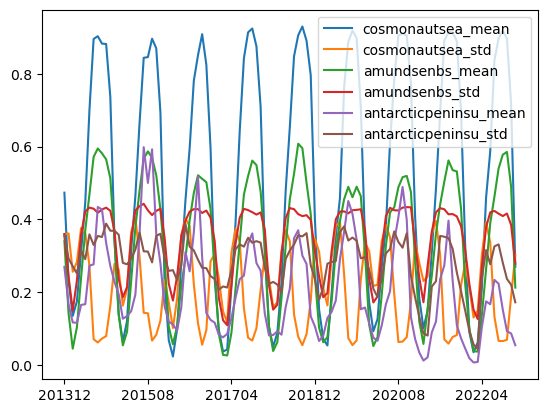

In [6]:
area_statis.to_excel("area_statis-sic.xlsx")
area_statis.plot()